In [48]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

In [49]:
start_time = time.time()  # Start time for the entire process
df_appgallery = pd.read_csv('/content/AppGallery.csv')
df_purchasing = pd.read_csv('/content/Purchasing.csv')

In [50]:
preprocess_start = time.time()  # Start time for preprocessing
df_appgallery = df_appgallery[['Ticket id', 'Interaction content', 'Type 1', 'Type 2', 'Type 3', 'Type 4']]
df_purchasing = df_purchasing[['Ticket id', 'Interaction content', 'Type 1', 'Type 2', 'Type 3', 'Type 4']]
df_appgallery.fillna('', inplace=True)
df_purchasing.fillna('', inplace=True)
df = pd.concat([df_appgallery, df_purchasing], ignore_index=True)
preprocess_end = time.time()  # End time for preprocessing
print(f"Time taken for data preprocessing: {preprocess_end - preprocess_start} seconds")


Time taken for data preprocessing: 0.007575273513793945 seconds


<ipython-input-50-c5a7fb899d66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appgallery.fillna('', inplace=True)
<ipython-input-50-c5a7fb899d66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchasing.fillna('', inplace=True)


In [51]:
encoding_start = time.time()  # Start time for encoding
ohe_type1 = OneHotEncoder(handle_unknown='ignore')
X_type1 = ohe_type1.fit_transform(df[['Type 1']]).toarray()
ohe_type2 = OneHotEncoder(handle_unknown='ignore')
y_type2 = ohe_type2.fit_transform(df[['Type 2']]).toarray()
ohe_type3 = OneHotEncoder(handle_unknown='ignore')
y_type3 = ohe_type3.fit_transform(df[['Type 3']]).toarray()
ohe_type4 = OneHotEncoder(handle_unknown='ignore')
y_type4 = ohe_type4.fit_transform(df[['Type 4']]).toarray()
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['Interaction content']).toarray()
X = np.hstack((X_tfidf, X_type1))
y = np.hstack((y_type2, y_type3, y_type4))
encoding_end = time.time()  # End time for encoding
print(f"Time taken for encoding and feature extraction: {encoding_end - encoding_start} seconds")


Time taken for encoding and feature extraction: 0.1886303424835205 seconds


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
training_start = time.time()
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
}
def evaluate_model(model, X_train, y_train, X_test, y_test):
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
    for i in range(y_train.shape[1]):
        unique_classes = np.unique(y_train[:, i])
        if len(unique_classes) < 2:
            continue
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        metrics['accuracy'].append(accuracy_score(y_test[:, i], y_pred))
        metrics['precision'].append(precision_score(y_test[:, i], y_pred, average='macro', zero_division=0))
        metrics['recall'].append(recall_score(y_test[:, i], y_pred, average='macro', zero_division=0))
        metrics['f1_score'].append(f1_score(y_test[:, i], y_pred, average='macro', zero_division=0))
    return {
        'accuracy': np.nanmean(metrics['accuracy']),
        'precision': np.nanmean(metrics['precision']),
        'recall': np.nanmean(metrics['recall']),
        'f1_score': np.nanmean(metrics['f1_score'])
    }
for name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} - Accuracy: {metrics['accuracy']}, Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1 Score: {metrics['f1_score']}")
training_end = time.time()  # End time for training
print(f"Time taken for model training and evaluation: {training_end - training_start} seconds")


RandomForest - Accuracy: 0.9623015873015872, Precision: 0.8423673139449871, Recall: 0.7777657238177105, F1 Score: 0.7915732873862246
GradientBoosting - Accuracy: 0.9563492063492062, Precision: 0.816555402306192, Recall: 0.7780509784098156, F1 Score: 0.7863683756556622
Time taken for model training and evaluation: 34.32157492637634 seconds


In [54]:
from sklearn.ensemble import VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', models['RandomForest']),
    ('gb', models['GradientBoosting']),
], voting='soft')
ensemble_start_time = time.time()  # Start time for ensemble process
for i in range(y_train.shape[1]):
    if len(np.unique(y_train[:, i])) < 2:
        continue
    ensemble_model.fit(X_train, y_train[:, i])
    y_pred_ensemble = ensemble_model.predict(X_test)
    ensemble_metrics['accuracy'].append(accuracy_score(y_test[:, i], y_pred_ensemble))
    ensemble_metrics['precision'].append(precision_score(y_test[:, i], y_pred_ensemble, average='macro', zero_division=0))
    ensemble_metrics['recall'].append(recall_score(y_test[:, i], y_pred_ensemble, average='macro', zero_division=0))
    ensemble_metrics['f1_score'].append(f1_score(y_test[:, i], y_pred_ensemble, average='macro', zero_division=0))
ensemble_end_time = time.time()  # End time for ensemble process
print(f"Total time taken for ensemble model fitting and evaluation: {ensemble_end_time - ensemble_start_time} seconds")
if ensemble_metrics['accuracy']:
    average_accuracy = np.mean(ensemble_metrics['accuracy'])
    print(f"Ensemble Model - Average Accuracy: {average_accuracy:.2f}")
    print(f"Precision: {np.mean(ensemble_metrics['precision']):.2f}, Recall: {np.mean(ensemble_metrics['recall']):.2f}, F1 Score: {np.mean(ensemble_metrics['f1_score']):.2f}")
else:
    print("No valid labels were processed.")

Total time taken for ensemble model fitting and evaluation: 32.650638818740845 seconds
Ensemble Model - Average Accuracy: 0.96
Precision: 0.82, Recall: 0.78, F1 Score: 0.79


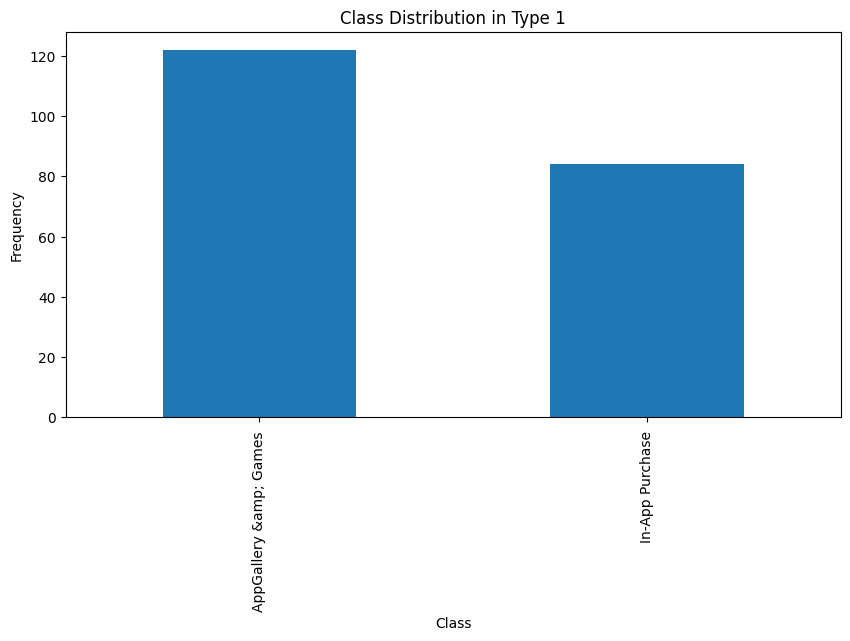

Percentage of each class in Type 1:
Type 1
AppGallery &amp; Games     59.223301
In-App Purchase            40.776699
Name: count, dtype: float64



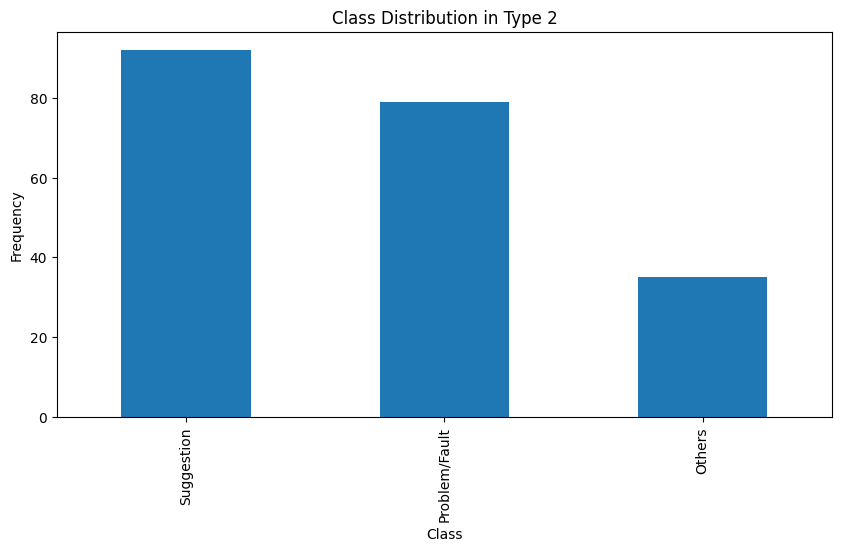

Percentage of each class in Type 2:
Type 2
Suggestion       44.660194
Problem/Fault    38.349515
Others           16.990291
Name: count, dtype: float64



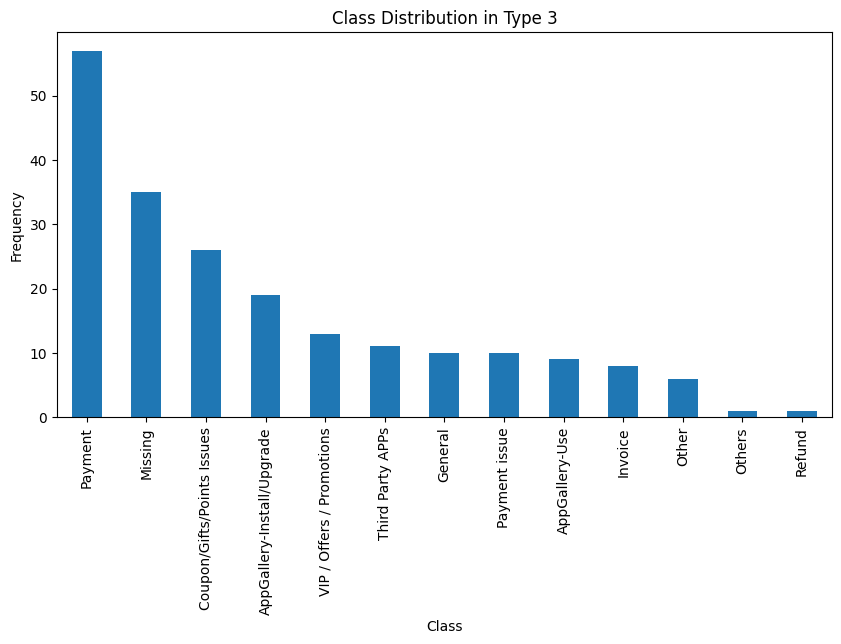

Percentage of each class in Type 3:
Type 3
Payment                       27.669903
Missing                       16.990291
Coupon/Gifts/Points Issues    12.621359
AppGallery-Install/Upgrade     9.223301
VIP / Offers / Promotions      6.310680
Third Party APPs               5.339806
General                        4.854369
Payment issue                  4.854369
AppGallery-Use                 4.368932
Invoice                        3.883495
Other                          2.912621
Others                         0.485437
Refund                         0.485437
Name: count, dtype: float64



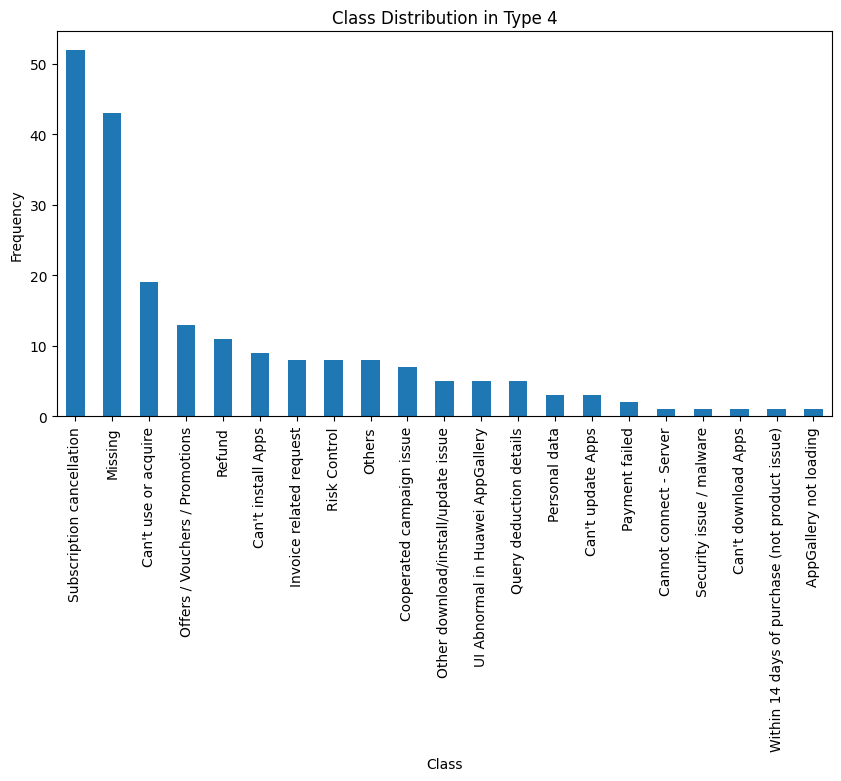

Percentage of each class in Type 4:
Type 4
Subscription cancellation                         25.242718
Missing                                           20.873786
Can't use or acquire                               9.223301
Offers / Vouchers / Promotions                     6.310680
Refund                                             5.339806
Can't install Apps                                 4.368932
Invoice related request                            3.883495
Risk Control                                       3.883495
Others                                             3.883495
Cooperated campaign issue                          3.398058
Other download/install/update issue                2.427184
UI Abnormal in Huawei AppGallery                   2.427184
Query deduction details                            2.427184
Personal data                                      1.456311
Can't update Apps                                  1.456311
Payment failed                                     0.9708

In [55]:
import matplotlib.pyplot as plt
df_appgallery = pd.read_csv('/content/AppGallery.csv')
df_purchasing = pd.read_csv('/content/Purchasing.csv')
df = pd.concat([df_appgallery, df_purchasing], ignore_index=True)
df = df[['Type 1', 'Type 2', 'Type 3', 'Type 4']]
df.fillna('Missing', inplace=True)
for column in df.columns:
    class_counts = df[column].value_counts()
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title(f'Class Distribution in {column}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()
    class_percentage = class_counts / len(df) * 100
    print(f"Percentage of each class in {column}:\n{class_percentage}\n")